## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [261]:
# Import libraries.
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

from collections import Counter

In [262]:
# Random state seed.
rseed = 42

## Load and explore data

In [263]:
# Import the dataset.
country_data = pd.read_csv('Country-data.csv')
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [264]:
# Check the shape.
country_data.shape

(167, 10)

In [265]:
# Check datatypes & counts.
country_data.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

In [266]:
country_data.info

<bound method DataFrame.info of                  country  child_mort  exports  health  imports  income  \
0            Afghanistan        90.2     10.0    7.58     44.9    1610   
1                Albania        16.6     28.0    6.55     48.6    9930   
2                Algeria        27.3     38.4    4.17     31.4   12900   
3                 Angola       119.0     62.3    2.85     42.9    5900   
4    Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   
..                   ...         ...      ...     ...      ...     ...   
162              Vanuatu        29.2     46.6    5.25     52.7    2950   
163            Venezuela        17.1     28.5    4.91     17.6   16500   
164              Vietnam        23.3     72.0    6.84     80.2    4490   
165                Yemen        56.3     30.0    5.18     34.4    4480   
166               Zambia        83.1     37.0    5.89     30.9    3280   

     inflation  life_expec  total_fer   gdpp  
0         9.44        56.2      

In [267]:
# Get descriptive statistics.
country_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [268]:
# Identify any missing data.
country_data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Preprocessing and Feature Selection

In [269]:
# Drop any non-numeric features (columns).
cluster_df = country_data.select_dtypes(exclude=['object'])
cluster_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [270]:
# Create a correlation map of features to explore relationships between features.
cluster_df.corr()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.318093,-0.200402,-0.127211,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,-0.318093,1.000000,-0.114408,0.737381,0.516784,-0.107294,0.316313,-0.320011,0.418725
health,-0.200402,-0.114408,1.000000,0.095717,0.129579,-0.255376,0.210692,-0.196674,0.345966
imports,-0.127211,0.737381,0.095717,1.000000,0.122406,-0.246994,0.054391,-0.159048,0.115498
income,-0.524315,0.516784,0.129579,0.122406,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,-0.107294,-0.255376,-0.246994,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,0.316313,0.210692,0.054391,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,-0.320011,-0.196674,-0.159048,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,0.418725,0.345966,0.115498,0.895571,-0.221631,0.600089,-0.454910,1.000000


<Axes: title={'center': 'Correlation Map of Features'}>

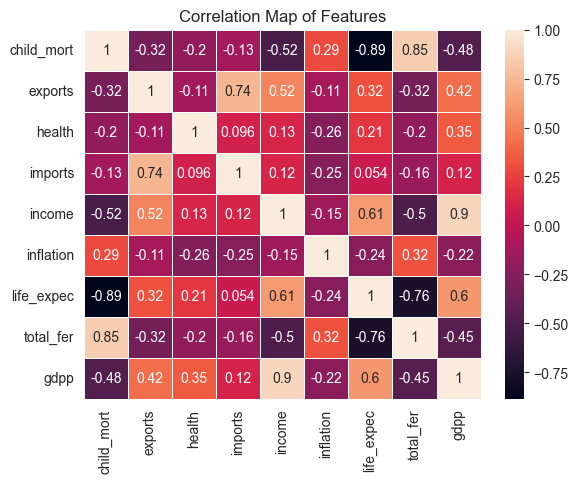

In [271]:
# Hint: Explore seaborn heatmap
plt.title('Correlation Map of Features')
sns.heatmap(cluster_df.corr(), annot=True, linewidths=.5)

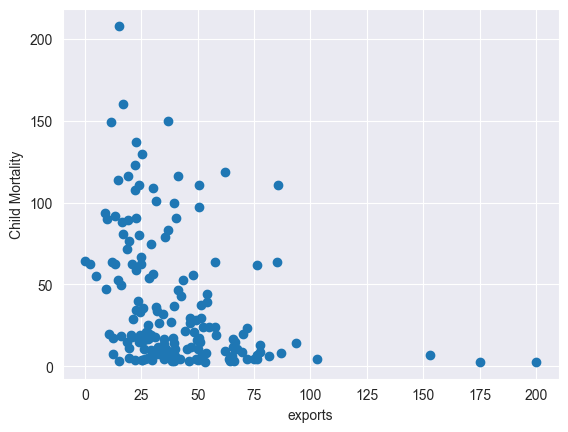

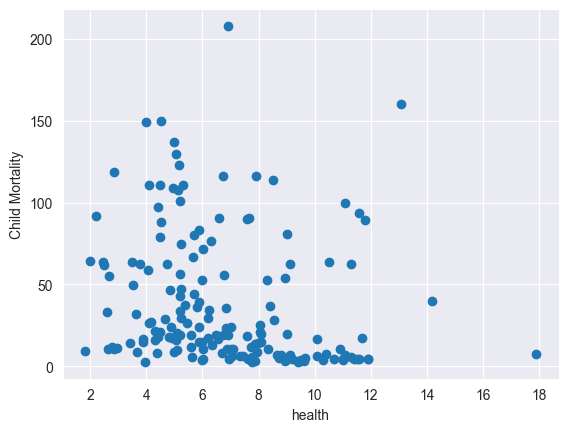

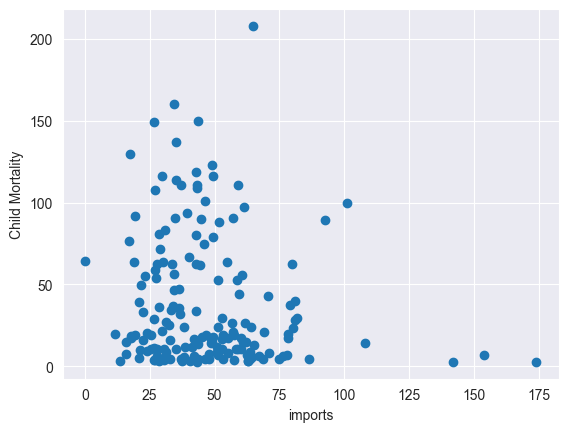

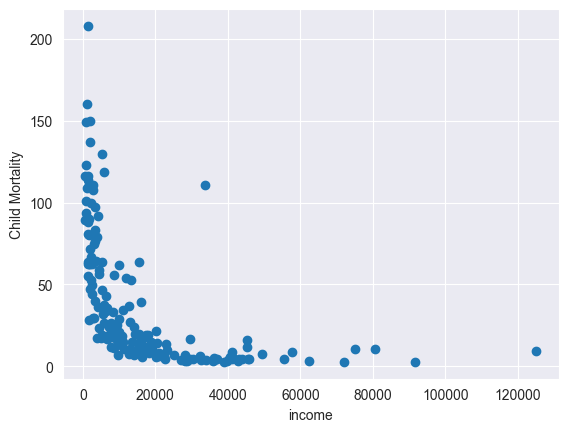

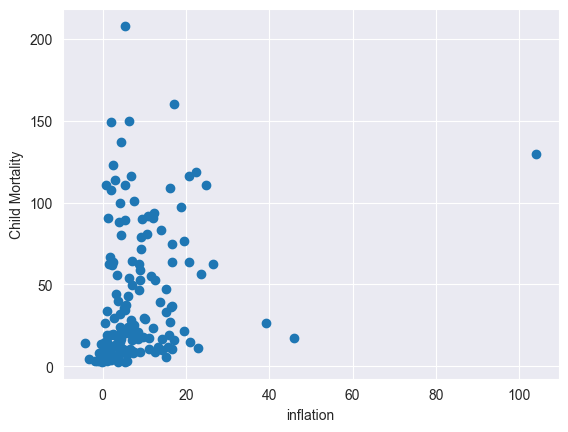

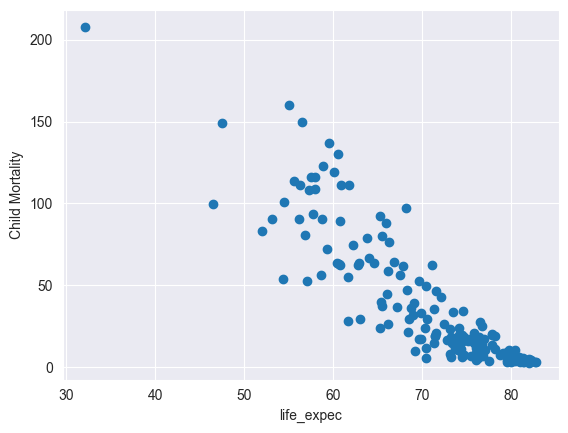

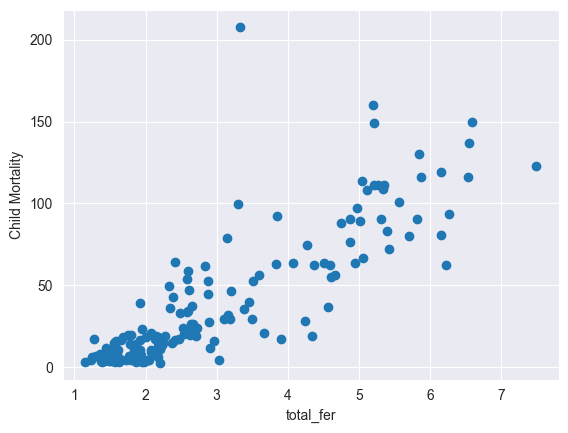

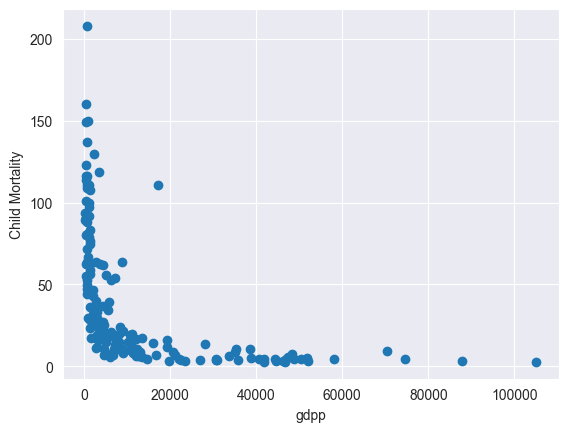

In [272]:
# Explore the continuous independent features against child_mort using scatter plots.
sns.set_style('darkgrid')
for f in cluster_df.columns[1:]:
  plt.scatter(cluster_df[f], cluster_df['child_mort'])
  plt.xlabel(f)
  plt.ylabel('Child Mortality')
  plt.show()

In [273]:
# Revisit the column names.
cluster_df.columns

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

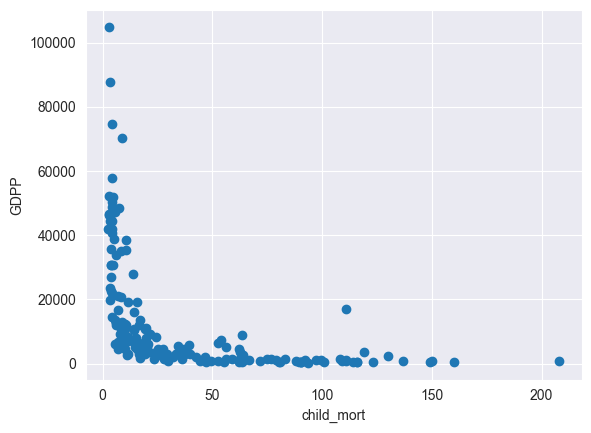

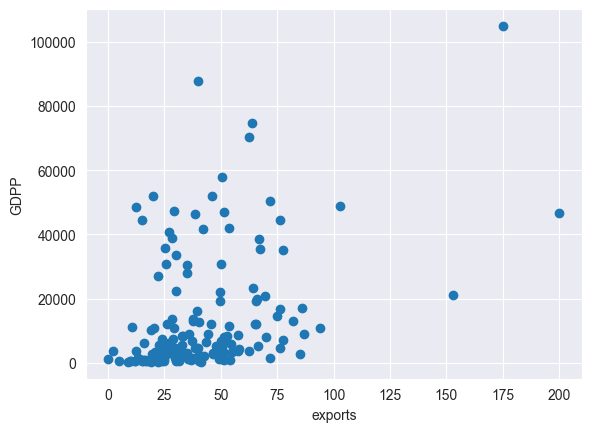

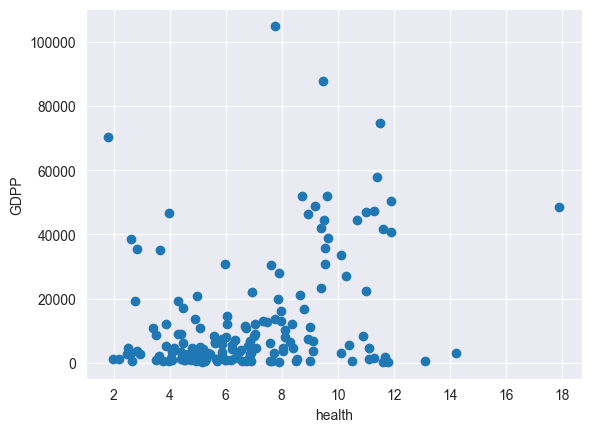

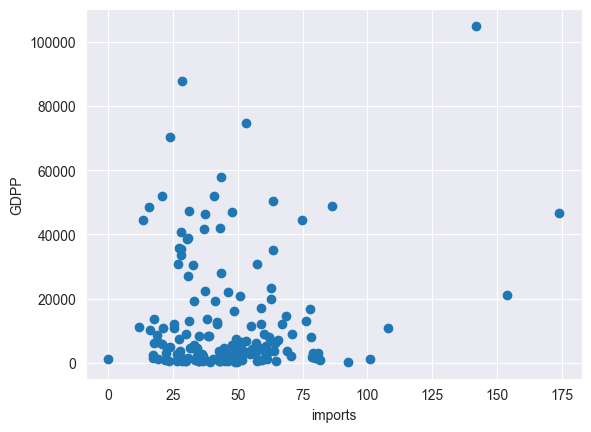

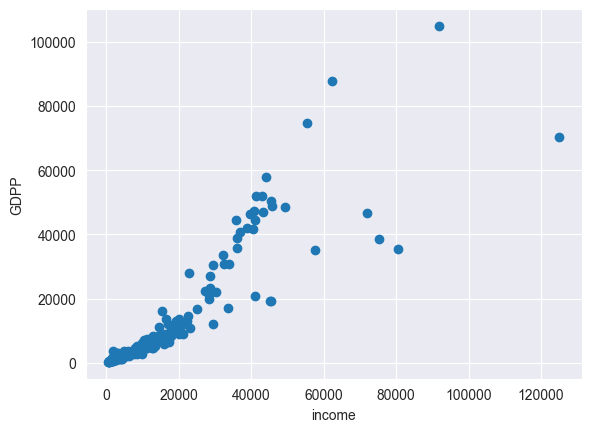

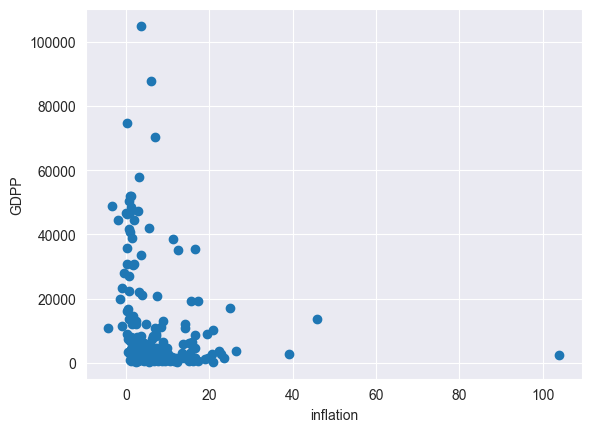

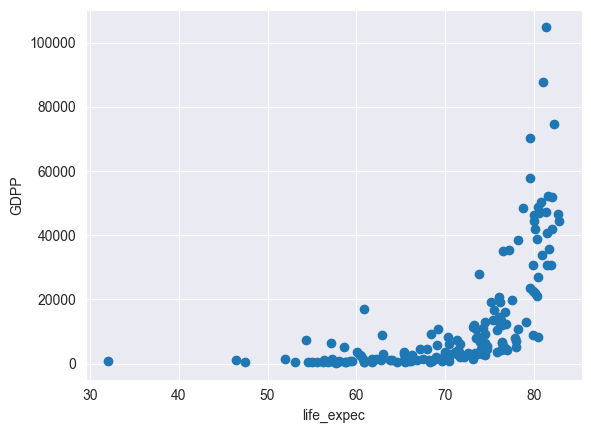

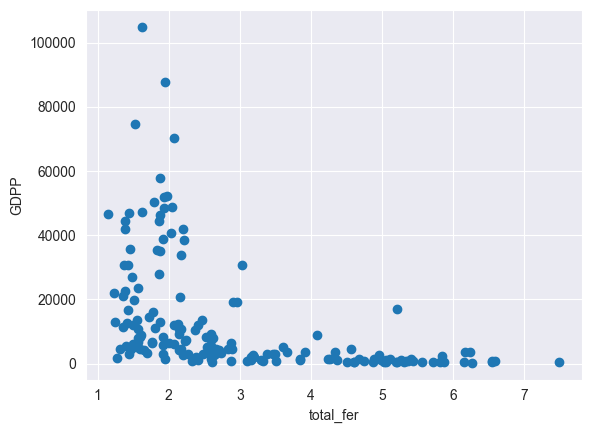

In [274]:
# Explore the continuous independent features against gdpp using scatter plots.
# According to PDF Tasks: 
# Plot nine different scatter plots with different combinations of variables
# against GDPP. For example: GDPP vs health.
# Not which of these plots looks the most promising for separating into clusters.
# Note: I can only create 8 plots.

for f in cluster_df.columns[:-1]:
  plt.scatter(cluster_df[f], cluster_df['gdpp'])
  plt.xlabel(f)
  plt.ylabel('GDPP')
  plt.show()

I cannot really see a plot that shows a perfect example for separating into clusters.  
However, the best one could be the health plot.

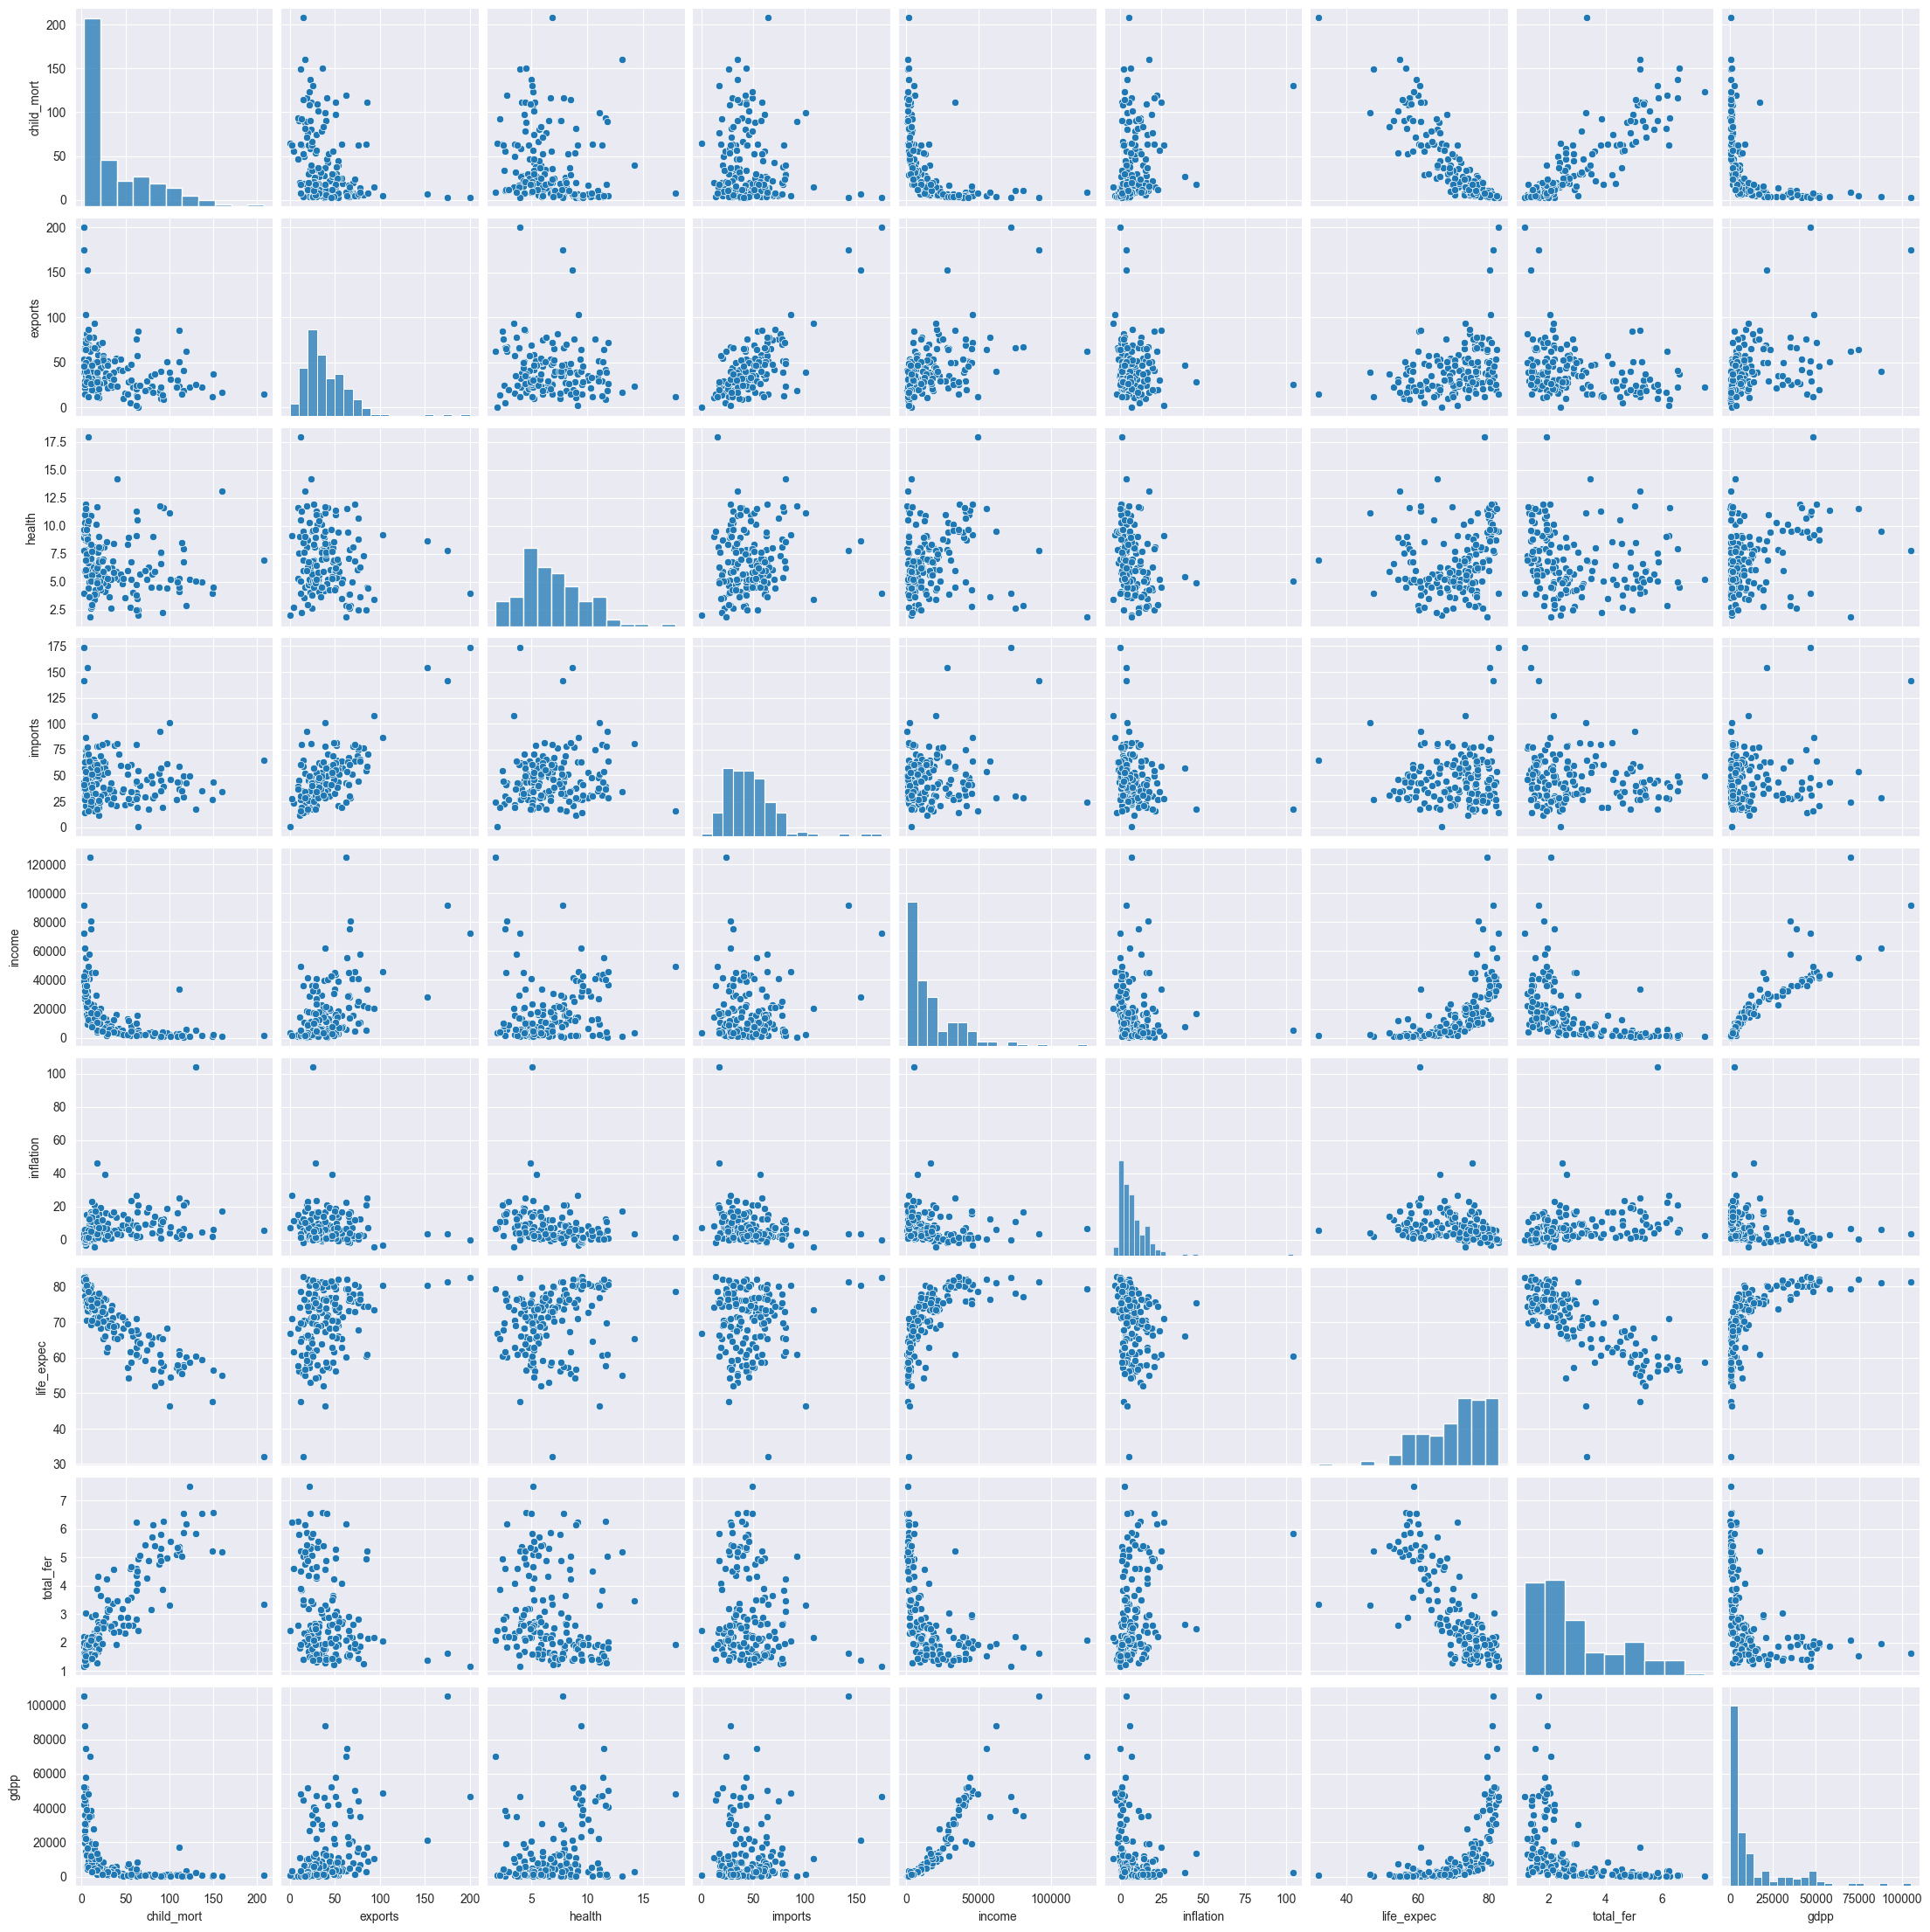

In [275]:
# Create a pair plot.
# Hint: Explore seaborn pairplot.
sns.pairplot(cluster_df)

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

- health  
- total fertility  
- GDPP  
- Income (?)
- Inflation (?)

### Scaling the Data

In [276]:
# Normalise the data using MinMaxScaler.
# Name the normalised dataframe "df_scaled".

# Fit the scaler on train data
sc = MinMaxScaler()
sc.fit(cluster_df)

# Apply the scaler on train and test data.
df_scaled = pd.DataFrame(sc.transform(cluster_df), columns=cluster_df.columns)

df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

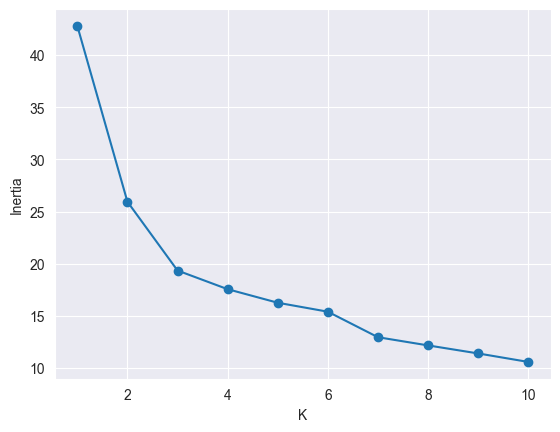

In [277]:
# Plot elbow curve.
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_


def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()


# Plot elbow curve using scaled dataset.
elbow_Kmeans(df_scaled)

Range between 2 and 4

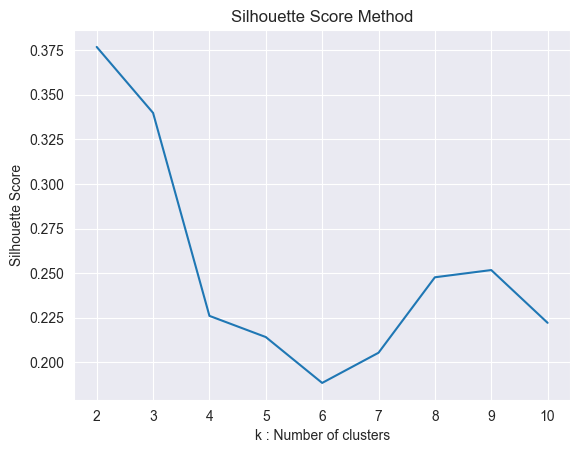

In [278]:
# Silhouette score method.
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

2 is the visible peak on this line plot. Therefore I choose 2.

## Fitting a K-Means Model with the selected K value

In [279]:
# Choose the number of clusters.
k = 2

# Perform K-Means clustering.
# Remember to set the random_state to rseed.
kmeans = KMeans(n_clusters=k, random_state=rseed, n_init="auto")
kmeans.fit(df_scaled)  

# Get cluster labels.
cluster_labels = kmeans.labels_

# Print results.
print("Cluster Labels:", cluster_labels)
print("Cluster Centers:", kmeans.cluster_centers_)
print("Inertia:", kmeans.inertia_)

Cluster Labels: [0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0
 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1
 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0
 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0]
Cluster Centers: [[0.40146942 0.14214329 0.28504435 0.25084123 0.02638133 0.14174879
  0.55599785 0.57384571 0.01645924]
 [0.06179145 0.23603364 0.32390349 0.27822623 0.18525772 0.09563176
  0.85793533 0.14105453 0.17313549]]
Inertia: 25.94736093352988


In [280]:
# Count the number of records in each cluster.
Counter(cluster_labels)

Counter({np.int32(1): 112, np.int32(0): 55})

In [281]:
# Check model performance with the silhouette coefficient.
silhouette_avg = round(silhouette_score(df_scaled, kmeans.labels_, metric='euclidean'), 2)
print(f"The average silhouette score for {kmeans.n_clusters} clusters is: {silhouette_avg}.")

The average silhouette score for 2 clusters is: 0.38.


## Predictions

In [282]:
# Add the predicted cluster label column to the original dataframe.
country_data['pred_cluster_label'] = cluster_labels

In [283]:
country_data.sample(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,pred_cluster_label
107,Myanmar,64.4,0.109,1.97,0.0659,3720,7.040,66.8,2.41,988,0
119,Peru,20.3,27.800,5.08,23.8000,9960,5.710,77.9,2.54,5020,1
79,Kazakhstan,21.5,44.200,4.29,29.9000,20100,19.500,68.4,2.60,9070,1
18,Bhutan,42.7,42.500,5.20,70.7000,6420,5.990,72.1,2.38,2180,1
43,Czech Republic,3.4,66.000,7.88,62.9000,28300,-1.430,77.5,1.51,19800,1
151,Tonga,17.4,12.400,5.07,60.3000,4980,3.680,69.9,3.91,3550,0
35,Colombia,18.6,15.900,7.59,17.8000,10900,3.860,76.4,2.01,6250,1
118,Paraguay,24.1,55.100,5.87,51.5000,7290,6.100,74.1,2.73,3230,1
134,Slovak Republic,7.0,76.300,8.79,77.8000,25200,0.485,75.5,1.43,16600,1
109,Nepal,47.0,9.580,5.25,36.4000,1990,15.100,68.3,2.61,592,1


## Visualisation of clusters

**Visualisation of clusters: child mortality vs gdpp**

In [284]:
# Visualisation of clusters: child mortality vs gdpp.
X_child = df_scaled[['child_mort','gdpp']].values.reshape(-1,2)  

I am interested if the best fit K for only those features would be different from 2.    
But that is only for my interest's sake. I will use the previously determined K for the calculations and models.

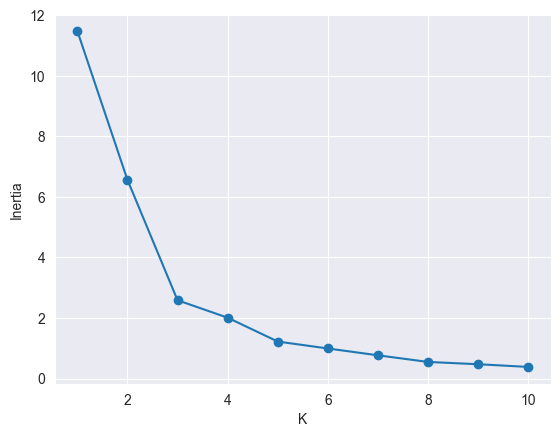

In [ ]:
# Use the previously defined function.
elbow_Kmeans(X_child)

It looks like there best fit K for the chosen features is in the range of 2-4. Therefore, I want to visualise all of those.

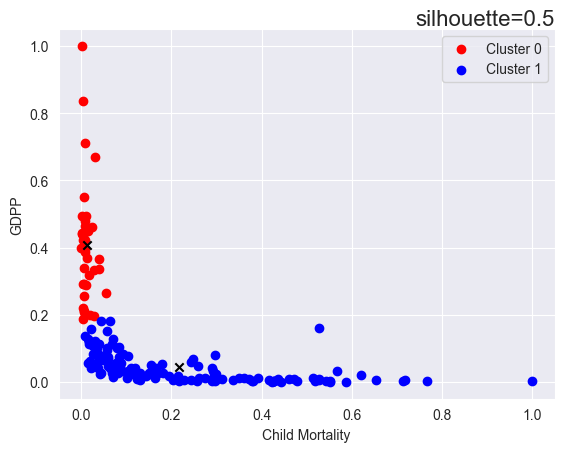

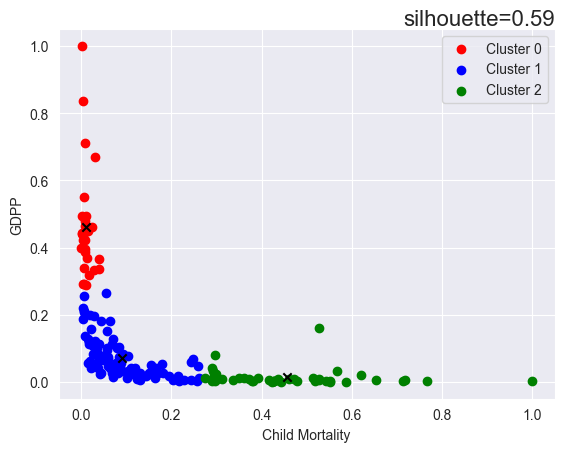

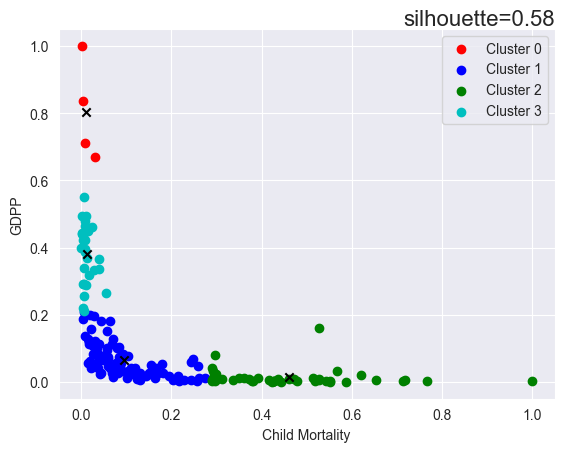

In [ ]:
# Define a function that visualises the clusters.
def scatter_Kmeans(x, k, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(X_child, kmeans.labels_, metric='euclidean'), 2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('Child Mortality')
    plt.ylabel('GDPP')
    plt.legend()
    plt.show()

for k in range(2,5):
  scatter_Kmeans(X_child, k, r=0)

3 brings about the best silhouette score. So if we had only looked at those features, that could have been the best amount of clusters.

**Visualisation of clusters: inflation vs gdpp**

In [287]:
# Visualisation of clusters: inflation vs gdpp.
X_inf = df_scaled[['inflation','gdpp']].values.reshape(-1,2)  

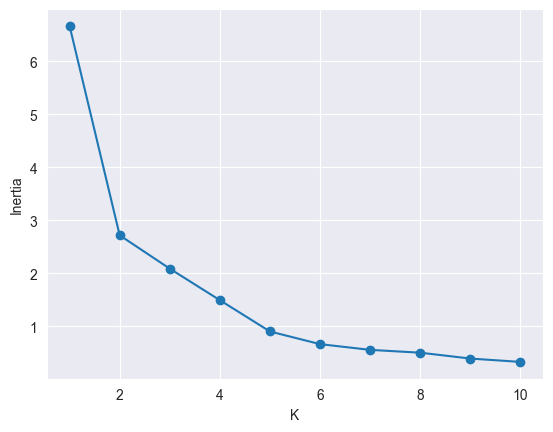

In [ ]:
# Use the previously defined function.
elbow_Kmeans(X_inf)

It looks like there best fit K for the chosen features is in the range of 2 and 5. But 2 clearly has the strongest 'bend'. So from this alone, I predict that 2 is the best fit.

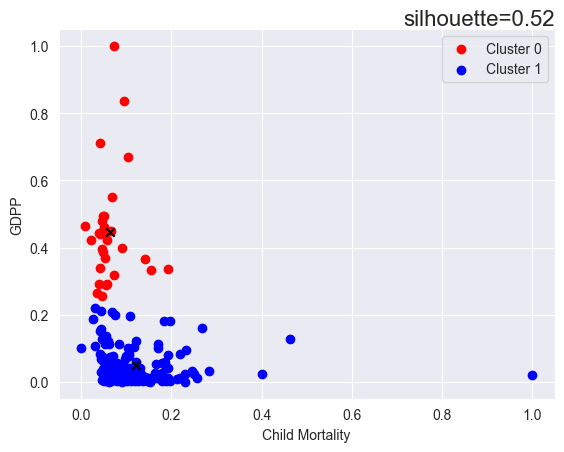

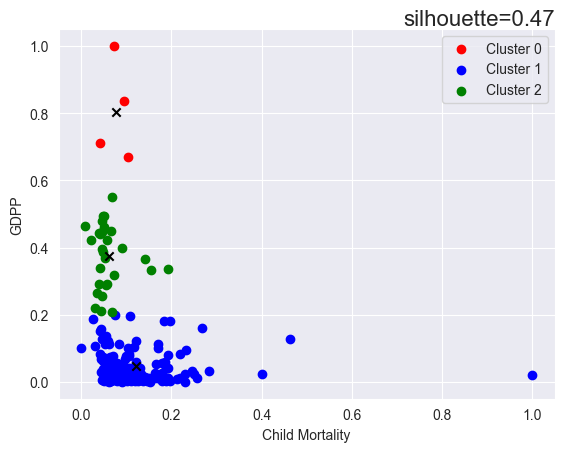

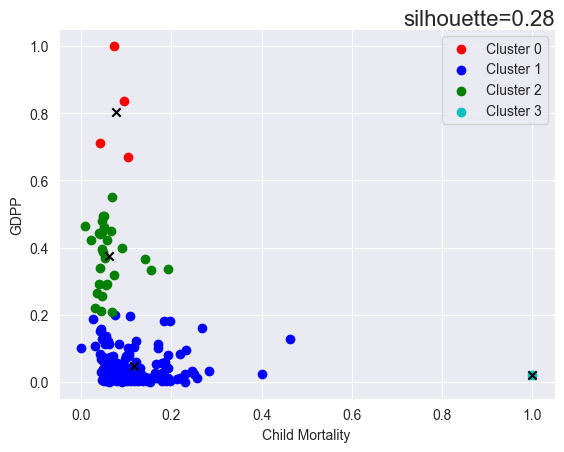

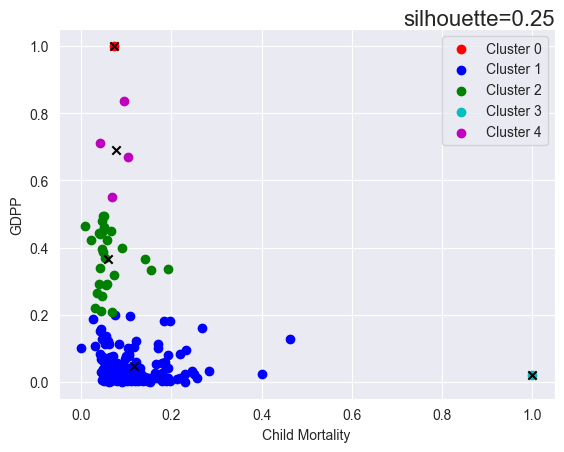

In [ ]:
# Use the previously defined function.
for k in range(2,6):
  scatter_Kmeans(X_inf, k, r=0)

As predicted, 2 is the best fit K for these features. 

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


In [290]:
country_data.groupby('pred_cluster_label')[['income']].mean()

,income
pred_cluster_label,
0,3890.600000
1,23653.392857


**Answer here:**  

I identified 2 clusters in the data frame.  
Countries with the predicted cluster label 0 could be labelled low income countries.  
Countries with the predicted cluster label 1 could be labelled high income countries.  
The reason for that is shown above. 